## Handle Imports

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D

import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import cv2
import os

## Config Variables

In [38]:
BASE_IMG_DIR = "data/"

EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224
LR = 1e-3

RANDOM_SEED = 42

TEST_SPLIT = 0.2

In [39]:
def info(msg):
    print(f"[INFO] {msg}\n")

In [40]:
df = pd.read_excel("Stroke _DCM _Train_Labels.xlsx")

## Remove unneeded rows and rename columns

In [41]:
# Drop second row and last row
df.drop(index=df.index[-1], axis=0, inplace=True)
df.drop(index=df.index[0], axis=0, inplace=True)

In [42]:
df.rename(columns = {'SERIES': "Positive", "Unnamed: 4": "TP", "Unnamed: 5": "Negative"}, inplace = True)

In [43]:
df.head()

,ID,IMAGE NAME,IMAGE COUNT,Positive,TP,Negative
1,1,STP21,50.0,26 to 44,19,31
2,2,STP22,50.0,26 to 46,21,29
3,3,STP23,50.0,26 to 42,17,33
4,4,STP24,50.0,26 to 46,21,29
5,5,STP25,50.0,26 to 45,20,30


## Create functions to generate image ranges for the data frame

In [44]:
def resolve_to_range(txt):
    txt = txt.split(",")
    _l = []
    
    for i in txt:
        a, b = [int(v) for v in i.split("to")]
        
        for j in range(a, b+1):
            _l.append(j)
            
    return _l

def sort_key(name):
    parts = name.split('.')
    keys = []
    for part in parts:
        if part.isdigit():
            keys.append(int(part))
        else:
            keys.append(part)
    return tuple(keys)
    
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0.0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

## Convert Positive column to have individual positive numbers

In [45]:
df.Positive = df.Positive.apply(resolve_to_range)
df.head()

,ID,IMAGE NAME,IMAGE COUNT,Positive,TP,Negative
1,1,STP21,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",19,31
2,2,STP22,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",21,29
3,3,STP23,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",17,33
4,4,STP24,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",21,29
5,5,STP25,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",20,30


## Create new DataFrame holding the ImageWise Data

In [116]:
dataset = {"Images": [], "Stroke": []}

for i in range(1, df.shape[0]+1):
    fn = df["IMAGE NAME"][i]
    pos_l = df.Positive[i]
    
    files = os.listdir(BASE_IMG_DIR + fn + " " + fn + "/" + "STUDY/")
    files = sorted(files, key=sort_key)
    
    for index, f in enumerate(files):
        dataset["Images"].append(f"{BASE_IMG_DIR}{fn} {fn}/STUDY/{f}")
        if index+1 in pos_l:
            dataset["Stroke"].append(1)
        else:
            dataset["Stroke"].append(0)

info("Total No. of Positive Samples: " + str(dataset["Stroke"].count(1)))
info("Total No. of Negative Samples: " + str(dataset["Stroke"].count(0)))

[INFO] Total No. of Positive Samples: 2109

[INFO] Total No. of Negative Samples: 3188



## Load the cleaned data into a new DataFrame

In [117]:
data_df = pd.DataFrame(dataset)
data_df.head()

,Images,Stroke
0,data/STP21 STP21/STUDY/IMG-0001-00001.jpg,0
1,data/STP21 STP21/STUDY/IMG-0001-00002.jpg,0
2,data/STP21 STP21/STUDY/IMG-0001-00003.jpg,0
3,data/STP21 STP21/STUDY/IMG-0001-00004.jpg,0
4,data/STP21 STP21/STUDY/IMG-0001-00005.jpg,0


## Load the images and convert them into a Numpy array

In [50]:
image_data = []
target = np.array(data_df.Stroke)

In [51]:
for fn in data_df.Images:
    image = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.reshape(image.shape[0], image.shape[1], 1)
    
    image_data.append(image)
    
image_data = np.array(image_data)

## Plot random images

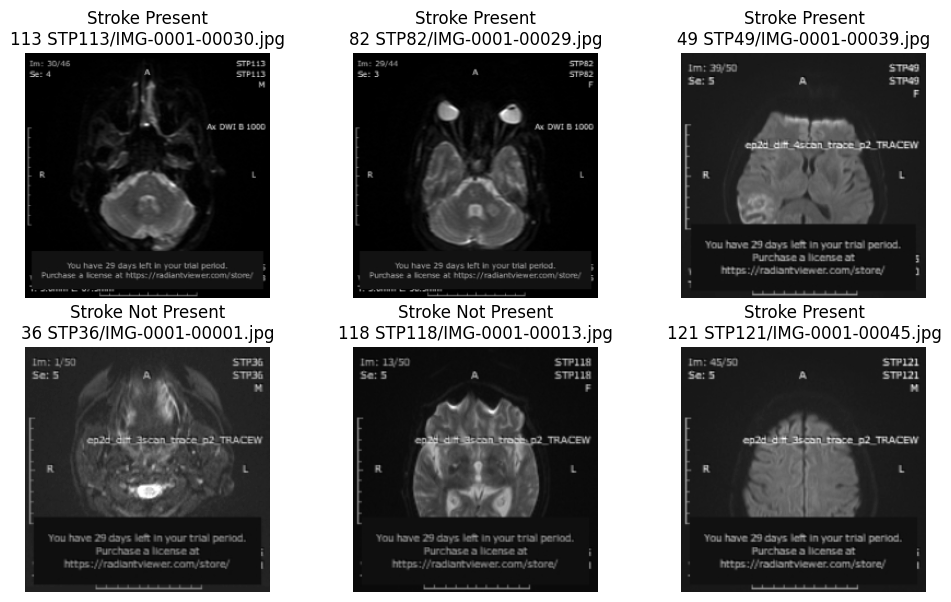

In [115]:
random_indexes = random.sample(range(len(image_data)), k=6)

fig, axs = plt.subplots(2, 3, figsize=(12, 7))

for (idx, c_ax) in zip(random_indexes, axs.flatten()):
    c_ax.imshow(image_data[idx], cmap="gray")
    if target[idx] == 1:
        title = "Stroke Present"
    else:
        title = "Stroke Not Present"
    c_ax.set_title(title + "\n" + str(data_df.Images[idx]).replace("data/STP", "").replace("STUDY/", ""))
    c_ax.axis("off")

In [98]:
X_train, X_test, y_train, y_test = train_test_split(image_data, target,
                                                    test_size=TEST_SPLIT,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True,
                                                    stratify=target)

a, b = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: a, 1: b}

## Create Data Augumentation

In [99]:
datagen_dict = {
    "rotation_range": 15,
    "width_shift_range": 0.2,
    "height_shift_range": 0.2,
    "shear_range": 0.2,
    "zoom_range": 0.2,
    "horizontal_flip": True,
    "fill_mode": "nearest"
}
testgen_dict = {}

if MODEL_TYPE == "mobilenet_v2":
    datagen_dict["preprocessing_function"] = tf.keras.applications.mobilenet_v2.preprocess_input
    testgen_dict["preprocessing_function"] = tf.keras.applications.mobilenet_v2.preprocess_input
    
elif MODEL_TYPE == "inception_v3":
    datagen_dict["preprocessing_function"] = tf.keras.applications.inception_v3.preprocess_input
    testgen_dict["preprocessing_function"] = tf.keras.applications.inception_v3.preprocess_input
    
elif MODEL_TYPE == "resnet_v2":
    datagen_dict["preprocessing_function"] = tf.keras.applications.resnet_v2.preprocess_input
    testgen_dict["preprocessing_function"] = tf.keras.applications.resnet_v2.preprocess_input

elif MODEL_TYPE == "vgg19":
    datagen_dict["preprocessing_function"] = tf.keras.applications.vgg19.preprocess_input
    testgen_dict["preprocessing_function"] = tf.keras.applications.vgg19.preprocess_input

elif MODEL_TYPE == "custom":
    datagen_dict["rescale"] = 1./255
    testgen_dict["rescale"] = 1./255

train_aug = ImageDataGenerator(**datagen_dict)
test_aug = ImageDataGenerator(**testgen_dict)

train_gen = train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE)
test_gen = test_aug.flow(X_test, y_test, batch_size=BATCH_SIZE)

training_steps_per_epoch = train_gen.n // BATCH_SIZE
test_steps_per_epoch = test_gen.n // BATCH_SIZE

info(f"Training Steps per Epoch: {training_steps_per_epoch}")
info(f"Test Steps per Epoch: {test_steps_per_epoch}")

[INFO] Training Steps per Epoch: 132

[INFO] Test Steps per Epoch: 33



## Initialise the model

In [100]:
def create_model():
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        BatchNormalization(),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        MaxPooling2D((2, 2)),
        
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        MaxPooling2D((2, 2)),
        
        Conv2D(512, (5, 5), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Conv2D(512, (5, 5), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        MaxPooling2D((2, 2)),

        # GlobalAveragePooling2D(),
        
        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Dense(1, activation='sigmoid')
    ])
    
    return model

def build_model():
    if COLOR_SPACE == "grayscale":
        depth = 1
        weight = None
    else:
        depth = 3
        weight = "imagenet"
        
    if MODEL_TYPE == "efficientnet_v2":
        base = tf.keras.applications.efficientnet_v2.EfficientNetV2S(weights=weight,
                                                                      include_top=False,
                                                                      input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, depth)))
        
    elif MODEL_TYPE == "mobilenet_v2":
        base = tf.keras.applications.mobilenet_v2.MobileNetV2(weights=weight,
                                                              include_top=False,
                                                              input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, depth)))
        
    elif MODEL_TYPE == "inception_v3":
        base = tf.keras.applications.inception_v3.InceptionV3(weights=weight,
                                                              include_top=False,
                                                              input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, depth)))
        
    elif MODEL_TYPE == "resnet_v2":
        base = tf.keras.applications.resnet_v2.ResNet101V2(weights=weight,
                                                           include_top=False,
                                                           input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, depth)))
        
    elif MODEL_TYPE == "vgg19":
        base = tf.keras.applications.vgg19.VGG19(weights=weight,
                                                 include_top=False,
                                                 input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, depth)))
        
    if weight == "imagenet":
        base.trainable = False

        for layer in base.layers:
            layer.trainable = False

    flatten = base.output
    flatten = Flatten()(flatten)
    dense = Dense(128, activation="relu")(flatten)
    bn = BatchNormalization()(dense)
    dropout = Dropout(0.25)(bn)
    dense = Dense(64, activation="relu")(dropout)
    bn = BatchNormalization()(dense)
    dropout = Dropout(0.25)(bb)
    dense = Dense(32, activation="relu")(dropout)
    bn = BatchNormalization()(dense)
    dropout = Dropout(0.25)(bb)
    dense = Dense(32, activation="relu")(dropout)
    bn = BatchNormalization()(dense)
    dropout = Dropout(0.25)(bb)
    dense = Dense(16, activation="relu")(dropout)
    prediction_layer = Dense(1, activation="sigmoid")(dense)
    model = Model(inputs=base.input, outputs=prediction_layer)

    return model

# model.summary()

In [ ]:
if MODEL_TYPE == "custom":
    model = create_model()
    
else:
    model = build_model()

In [101]:
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=LR, weight_decay=0.004),
              metrics=[f1_score, "accuracy"],
              loss="binary_crossentropy")

## Create callbacks to save the best model and stop training early if loss doesn't improve

In [102]:
save_best = tf.keras.callbacks.ModelCheckpoint(f"model_brainstroke.h5",
                                               monitor="val_f1_score",
                                               mode="max",
                                               save_best_only=True,
                                               verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_f1_score",
                                                  mode="max",
                                                  patience=15)

In [103]:
history = model.fit(train_gen,
                    steps_per_epoch=training_steps_per_epoch,
                    validation_data=test_gen,
                    validation_steps=test_steps_per_epoch,
                    epochs=EPOCHS,
                    class_weight=class_weights,
                    callbacks=[save_best, early_stopping])

Epoch 1/50
132/132 [==============================] - ETA: 0s - loss: 0.6799 - f1_score: 0.5835 - accuracy: 0.6108
Epoch 1: val_f1_score did not improve from -inf
132/132 [==============================] - 106s 732ms/step - loss: 0.6799 - f1_score: 0.5835 - accuracy: 0.6108 - val_loss: 40.2012 - val_f1_score: nan - val_accuracy: 0.6004
Epoch 2/50
132/132 [==============================] - ETA: 0s - loss: 0.5395 - f1_score: 0.6962 - accuracy: 0.7227
Epoch 2: val_f1_score did not improve from -inf
132/132 [==============================] - 96s 726ms/step - loss: 0.5395 - f1_score: 0.6962 - accuracy: 0.7227 - val_loss: 4.0154 - val_f1_score: nan - val_accuracy: 0.6023
Epoch 3/50
132/132 [==============================] - ETA: 0s - loss: 0.4767 - f1_score: 0.7328 - accuracy: 0.7662
Epoch 3: val_f1_score improved from -inf to 0.50418, saving model to model_brainstroke.h5
132/132 [==============================] - 99s 747ms/step - loss: 0.4767 - f1_score: 0.7328 - accuracy: 0.7662 - val_loss

## Load the best performing model into memory

In [109]:
model = tf.keras.models.load_model("model_brainstroke.h5", compile=False)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=LR, weight_decay=0.004),
              metrics=[f1_score, "accuracy"],
              loss="binary_crossentropy")

## Plot the Train-Test Loss Curve

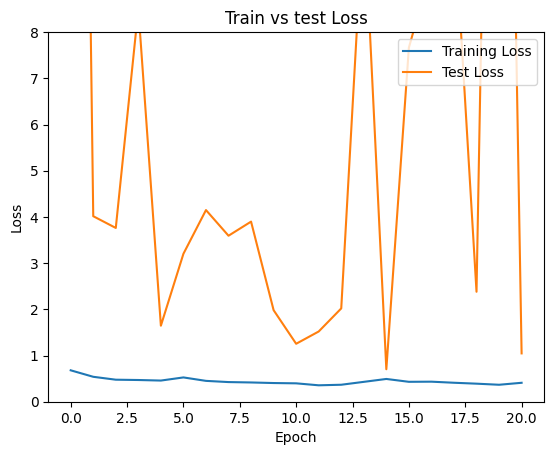

In [106]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train vs test Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim(0, 8)
plt.legend(["Training Loss", "Test Loss"], loc="upper right")
plt.show()

## Predict on the Test split and calculate metrics

In [110]:
pred = model.predict(test_gen, verbose=1)
pred

34/34 [==============================] - 4s 116ms/step


array([[0.9956701 ],
       [0.9630581 ],
       [0.9656705 ],
       ...,
       [0.9831942 ],
       [0.98853767],
       [0.8628959 ]], dtype=float32)

In [111]:
metrics.f1_score(y_test, np.round(pred))

0.6973544973544974

In [112]:
metrics.confusion_matrix(y_test, np.round(pred))

array([[241, 353],
       [107, 359]])

## Start Predicting on the Test Data

In [113]:
results = {"SN": [], "Label": []}
for f in os.listdir("test"):
    image = cv2.imread("test/" + f, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.reshape(IMG_SIZE, IMG_SIZE, 1)
    image = image/255.0

    b = np.expand_dims(image, axis=0)
    v = model.predict(b)[0]
    results["SN"].append(int(f.replace(".jpg", "")))
    results["Label"].append(int(np.round(v)))

1/1 [==============================] - 0s 20ms/step


## Insert the predicted Data into a DataFrame

In [114]:
result_df = pd.DataFrame(results)
result_df = result_df.sort_values("SN")
result_df.head()

,SN,Label
36,1,1
118,2,1
31,3,1
147,4,1
87,5,1


In [96]:
result_df.to_csv("test_new.csv")